In [1]:
import sys
sys.path.append('..')

from scripts.open_preprocess_racmo import *
from scripts.paths import *
from scripts.dicts import *

import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np
import xarray as xr
import pandas as pd
import os

folder_base = "/Volumes/imau02/rapid/Anneke/"


Pathdata: /Volumes/imau01/rapid/RACMO2.3p2/FGRN055


Area per region

In [80]:
# open area per region
df_area = pd.read_csv(pathDataTemp + "area_per_region.csv", index_col=0)
# format as %
(df_area/ df_area.sum(0)).applymap(lambda x: f"{x:.0%}")

/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_78021/149362348.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  (df_area/ df_area.sum(0)).applymap(lambda x: f"{x:.0%}")


,LSM,Ice,Tundra,Fjord
SE,9%,9%,6%,10%
SW,11%,10%,18%,12%
CE,12%,12%,10%,22%
CW,17%,17%,15%,20%
NE,23%,23%,23%,17%
NW,13%,15%,4%,7%
NO,16%,14%,25%,12%


# CARRA 

In [81]:
precip_carra_per_basin = "/Volumes/imau02/rapid/Anneke/CARRA/Yearly/RACMOgrid/fjords_only/total_precipitation.CARRA.west_domain.2009-2023.1km.YY.fjords_only.per_basin.nc"
ds_precip_carra_per_basin_yearly = xr.open_dataset(precip_carra_per_basin)

In [82]:

# df = ds_precip_carra_per_basin.to_dataframe().reset_index()
# df['section_numbers_adjusted'] = df['section_numbers_adjusted'].replace(dict_Moug)
# ds_precip_carra_per_basin = df.to_xarray()


In [83]:
monthly_precip_cara = "/Volumes/imau02/rapid/Anneke/CARRA/Monthly/RACMOgrid/fjords_only/total_precipitation.CARRA.west_domain.2009-2023.1km.MM.fjords_only.per_basin.nc"
ds_month = xr.open_dataset(monthly_precip_cara)


In [84]:
monthly_precip_cara_mean = "/Volumes/imau02/rapid/Anneke/CARRA/Monthly/RACMOgrid/fjords_only/total_precipitation.CARRA.west_domain.2009-2023.1km.MM.fjords_only.mean_per_basin.nc"
ds_month_mean = xr.open_dataset(monthly_precip_cara_mean)

base unit kg /m2 average 
we sum it over all time 
its defined as the total precipitation over 24, 12 hours after the date
but now we sum it over space, which gives us kg/m2 *1000 m * 1000m 
1000 kg is one tonne
so 1e6 kg is one kt





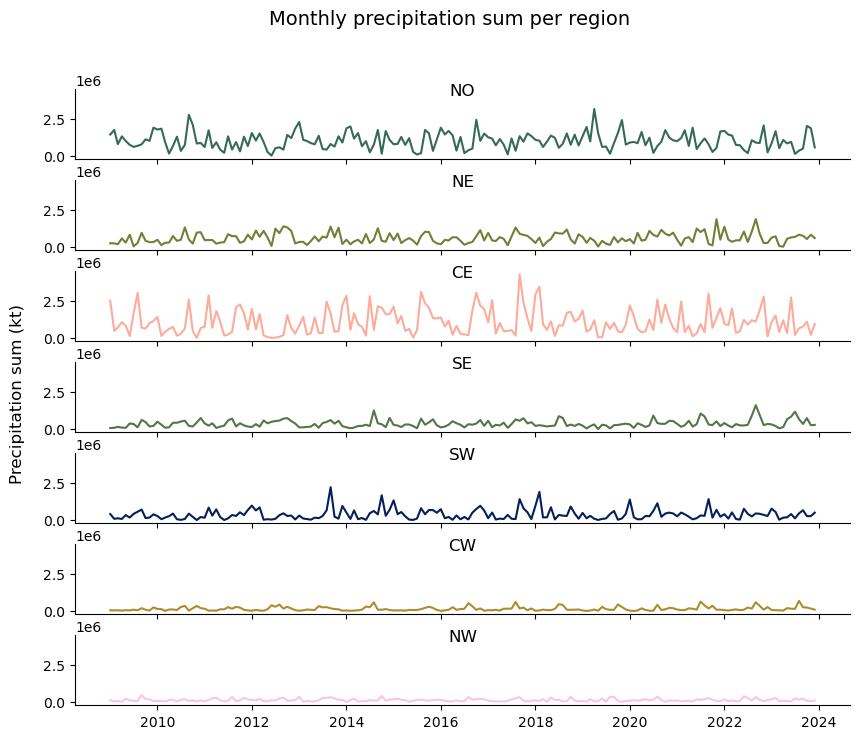

In [85]:
fig, axs = plt.subplots(len(ds_month['section_numbers_adjusted']), 1, figsize=(10, 8), sharex=True, sharey=True)

for i, section_number in enumerate(ds_month['section_numbers_adjusted'].values):
    ds_section = ds_month.sel(section_numbers_adjusted=section_number)
    axs[i].plot(ds_section['time'], ds_section['precip'], color=dict_region_colors[section_number])
    axs[i].set_title(f'{dict_Moug[section_number]}', y=0.8)

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.text(0.06, 0.5, 'Precipitation sum (kt)', va='center', rotation='vertical', fontsize = 12)
fig.suptitle('Monthly precipitation sum per region', fontsize = 14)
plt.subplots_adjust(hspace=0.3)
plt.show()

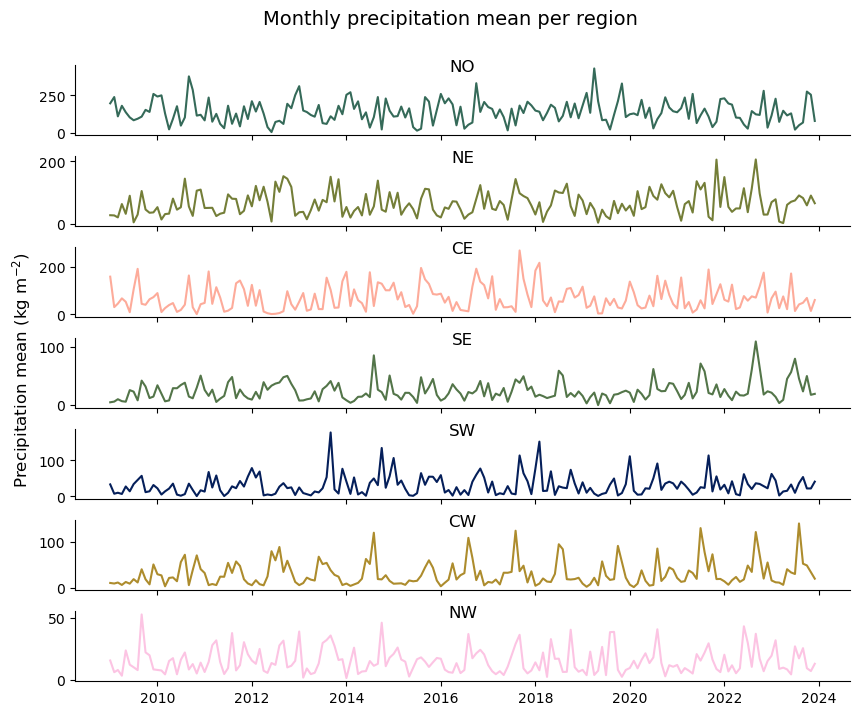

In [11]:
fig, axs = plt.subplots(len(ds_month_mean['section_numbers_adjusted']), 1, figsize=(10, 8), sharex=True, )

for i, section_number in enumerate(ds_month_mean['section_numbers_adjusted'].values):
    ds_section = ds_month_mean.sel(section_numbers_adjusted=section_number)
    axs[i].plot(ds_section['time'], ds_section['precip'], color=dict_region_colors[section_number])
    axs[i].set_title(f'{dict_Moug[section_number]}', y=0.8)

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.text(0.06, 0.5, r'Precipitation mean (kg m$^{-2}$)', va='center', rotation='vertical', fontsize = 12)
fig.suptitle('Monthly precipitation mean per region', fontsize = 14, y=0.95)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [183]:
dsPrecipFjords = xr.open_mfdataset(pathDataTemp + "RACMO2.3p2_1km_precip_fjords_Annual_1958_2023.nc")
dsPrecipFjordsAnnualRACMO_58_23 = dsPrecipFjords.copy(deep=True)
mask_sections = (
    folder_base
    + "RACMO2.3p2/FGRN055/Downscaling_GR/Mask_adjusted_section_numbers_slater_may24.nc"
)
dsmask_sections = xr.open_mfdataset(mask_sections)
dsPrecipFjordsSectormm_mean = dsPrecipFjords['precipcorr'].groupby(dsmask_sections['section_numbers_adjusted']).sum()


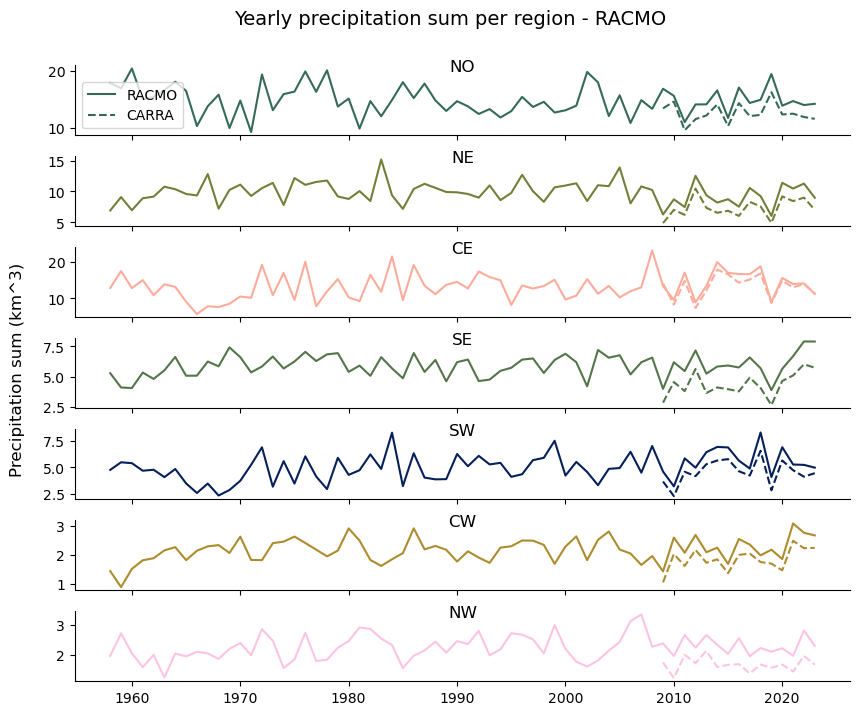

In [66]:
fig, axs = plt.subplots(len(dsPrecipFjordsSectormm_mean['section_numbers_adjusted']), 1, figsize=(10, 8), sharex=True, )

for i, section_number in enumerate(dsPrecipFjordsSectormm_mean['section_numbers_adjusted'].values):
    ds_section = dsPrecipFjordsSectormm_mean.sel(section_numbers_adjusted=section_number)
    time_array = pd.to_datetime(dsPrecipFjordsSectormm_mean['time'].dt.strftime('%Y') + '-01-01')
    axs[i].plot(time_array, ds_section, color=dict_region_colors[section_number], label='RACMO')
    axs[i].set_title(f'{dict_Moug[section_number]}', y=0.8)
    # for carra
    ds_section = ds_precip_carra_per_basin_yearly.sel(section_numbers_adjusted=section_number)/1e6
    # shift time by 6 months
    axs[i].plot(ds_section['time'], ds_section['precip'], color=dict_region_colors[section_number], linestyle='--', label='CARRA')
    

axs[0].legend()
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.text(0.06, 0.5, 'Precipitation sum (km^3)', va='center', rotation='vertical', fontsize = 12)
fig.suptitle('Yearly precipitation sum per region - RACMO', fontsize = 14, y=0.95)
plt.subplots_adjust(hspace=0.3)
# set xlim 
# plt.xlim(['2000-01-01','2024-01-01'])

plt.show()

In [63]:
pd.to_datetime(dsPrecipFjordsSectormm_mean['time'].dt.strftime('%Y') + '-01-01')

DatetimeIndex(['1958-01-01', '1959-01-01', '1960-01-01', '1961-01-01',
               '1962-01-01', '1963-01-01', '1964-01-01', '1965-01-01',
               '1966-01-01', '1967-01-01', '1968-01-01', '1969-01-01',
               '1970-01-01', '1971-01-01', '1972-01-01', '1973-01-01',
               '1974-01-01', '1975-01-01', '1976-01-01', '1977-01-01',
               '1978-01-01', '1979-01-01', '1980-01-01', '1981-01-01',
               '1982-01-01', '1983-01-01', '1984-01-01', '1985-01-01',
               '1986-01-01', '1987-01-01', '1988-01-01', '1989-01-01',
               '1990-01-01', '1991-01-01', '1992-01-01', '1993-01-01',
               '1994-01-01', '1995-01-01', '1996-01-01', '1997-01-01',
               '1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
      

In [12]:
# if the variable is already in memory
if not 'dsPrecipFjordsSectormm' in locals():
    print("loading")
    dsPrecipFjords = xr.open_dataset(pathDataTemp + "RACMO2.3p2_1km_precip_fjords.nc")
    dsPrecipFjords['Mouginot_basins'] = mask_tundra_sector_1k["Basins_ocean"]

dsPrecipFjordsSector = dsPrecipFjordsSectormm*1e6/1000./1.e9
dfPrecipFjordsSector = dsPrecipFjordsSector.to_dataframe().reset_index().set_index('time').pivot(columns='Mouginot_basins').rename(columns=dict_Moug)
dfPrecipFjordsSector.columns = dfPrecipFjordsSector.columns.get_level_values(1)
# dfPrecipFjordsSector = dfPrecipFjordsSector.drop(columns=0)
dfPrecipFjordsSector

loading


NameError: name 'mask_tundra_sector_1k' is not defined

/Users/annek/opt/anaconda3/envs/phdIIfresh/lib/python3.12/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/annek/opt/anaconda3/envs/phdIIfresh/lib/python3.12/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  retur

In [75]:
### 
# This script bulk downloads 3-hourly CARRA data from the CDS datastore, 
# and saves the data in one GRIB file per variable per month in different subfolders sorted per year.
# The code checks if files already exist in the download folders.
# Make sure the parameters are changed ! And always keep the same naming convention
###

import itertools
import os
from tqdm import tqdm


base_folder ='/Volumes/imau02/rapid/Anneke/CARRA/3-hourly/'
names = 'CARRA'
domains = 'west_domain'
level_types = 'surface_or_atmosphere'
variables = list(['surface_runoff',])
product_types = 'forecast'
years =  list(range(1991,2024+1))#[::-1]
months = list(range(1,12+1))
leadtimes_hour=  ['3', '6', '9', '12', '15', '18', '21', '24' ]
time =  ['00:00']
time_interval = "24h"

# Initialize lists
existing_files = []
non_existing_files = []

# no need to change this
for (year, month, variable, ) in (list(itertools.product(years, months, variables))):
    ofile = ".".join([variable,names,domains,product_types,time_interval,str(year),str(month),'grib']) # similar naming convention as RACMO
    ofolder = base_folder
    # make year folder if is does not exist


  # check if data is not already available
    if os.path.isfile(ofolder + ofile): 
        print(f'File for {year}-{month} already exists.')
        existing_files.append(ofolder + ofile)
    else:
        print(f'File for {year}-{month} does not exist.')
        non_existing_files.append(ofolder + ofile)

print(f'Existing files: {len(existing_files)}')
print(f'Non existing files: {len(non_existing_files)}')

File for 1991-1 already exists.
File for 1991-2 already exists.
File for 1991-3 already exists.
File for 1991-4 already exists.
File for 1991-5 already exists.
File for 1991-6 already exists.
File for 1991-7 already exists.
File for 1991-8 already exists.
File for 1991-9 already exists.
File for 1991-10 already exists.
File for 1991-11 already exists.
File for 1991-12 already exists.
File for 1992-1 already exists.
File for 1992-2 already exists.
File for 1992-3 already exists.
File for 1992-4 already exists.
File for 1992-5 already exists.
File for 1992-6 already exists.
File for 1992-7 already exists.
File for 1992-8 already exists.
File for 1992-9 already exists.
File for 1992-10 already exists.
File for 1992-11 already exists.
File for 1992-12 already exists.
File for 1993-1 already exists.
File for 1993-2 already exists.
File for 1993-3 already exists.
File for 1993-4 already exists.
File for 1993-5 already exists.
File for 1993-6 already exists.
File for 1993-7 already exists.
Fi

In [76]:
non_existing_files

['/Volumes/imau02/rapid/Anneke/CARRA/3-hourly/surface_runoff.CARRA.west_domain.forecast.24h.2024.1.grib',
 '/Volumes/imau02/rapid/Anneke/CARRA/3-hourly/surface_runoff.CARRA.west_domain.forecast.24h.2024.2.grib',
 '/Volumes/imau02/rapid/Anneke/CARRA/3-hourly/surface_runoff.CARRA.west_domain.forecast.24h.2024.3.grib',
 '/Volumes/imau02/rapid/Anneke/CARRA/3-hourly/surface_runoff.CARRA.west_domain.forecast.24h.2024.4.grib',
 '/Volumes/imau02/rapid/Anneke/CARRA/3-hourly/surface_runoff.CARRA.west_domain.forecast.24h.2024.5.grib',
 '/Volumes/imau02/rapid/Anneke/CARRA/3-hourly/surface_runoff.CARRA.west_domain.forecast.24h.2024.6.grib',
 '/Volumes/imau02/rapid/Anneke/CARRA/3-hourly/surface_runoff.CARRA.west_domain.forecast.24h.2024.7.grib',
 '/Volumes/imau02/rapid/Anneke/CARRA/3-hourly/surface_runoff.CARRA.west_domain.forecast.24h.2024.8.grib',
 '/Volumes/imau02/rapid/Anneke/CARRA/3-hourly/surface_runoff.CARRA.west_domain.forecast.24h.2024.9.grib',
 '/Volumes/imau02/rapid/Anneke/CARRA/3-hourly/

In [86]:
import xarray as xr
precipitation_1991_2008_sum = "/Volumes/imau02/rapid/Anneke/CARRA/Yearly/RACMOgrid/fjords_only/total_precipitation.CARRA.west_domain.1991-2008.1km.YY.fjords_only.sum_per_basin.nc"
ds_precipitation_1991_2008_sum = xr.open_dataset(precipitation_1991_2008_sum)

precipitation_2009_2023_sum = "/Volumes/imau02/rapid/Anneke/CARRA/Yearly/RACMOgrid/fjords_only/total_precipitation.CARRA.west_domain.2009-2023.1km.YY.fjords_only.per_basin.nc"
ds_precipitation_2009_2023_sum = xr.open_dataset(precipitation_2009_2023_sum)



In [88]:
ds_precip_carra_1991_2023_sum = xr.concat([ds_precipitation_1991_2008_sum, ds_precipitation_2009_2023_sum], dim='time')

ds_precip_carra_1991_2023_sum.to_netcdf("/Volumes/imau02/rapid/Anneke/CARRA/Yearly/RACMOgrid/fjords_only/total_precipitation.CARRA.west_domain.1991-2023.1km.YY.fjords_only.sum_per_basin.nc")

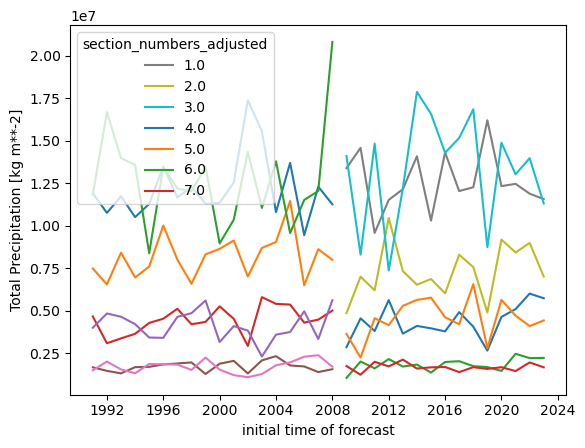

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ds_precipitation_1991_2008_sum['precip'].plot.line(x='time', hue='section_numbers_adjusted', ax=ax)
ds_precipitation_2009_2023_sum['precip'].plot.line(x='time', hue='section_numbers_adjusted', ax=ax)

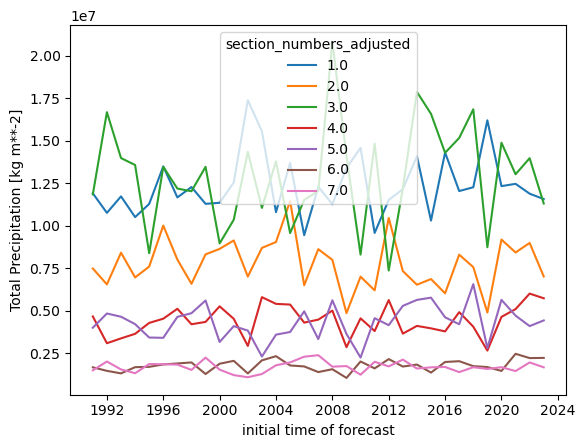

In [11]:
ds_precip_carra_2008_2023_sum['precip'].plot.line(x='time', hue='section_numbers_adjusted',)

# RACMO

In [166]:
pathRACMO_fjords = pathAnnekeFolderIMAU02+"//Downscaling_GR/Monthly/fjords_only/"

In [167]:
variable = "precip"
version = 'RACMO2.3p2'
domains = 'FGRN055'
forcing = 'ERA5_3h'
names = "_".join([version,forcing, domains])
product_types = 'forecast'
time_interval = "MM"
spatial_resolution = '1km'
extra = "fjords"

ofile = ".".join([variable,str(years[0])+"-"+str(years[-1]),names, spatial_resolution,time_interval,extra, 'nc']) # similar naming convention as RACMO

In [168]:
print(xr.__version__)

2024.5.0


In [169]:
# This reads all and combines them into one dataset

# time_resolution = 'Monthly'
# spatial_resolution = '1k'

# years= ['1990', '2023']

# dsPrecipMonth = read_RACMO("1k",time_resolution, years, variable="precip", since_1940=False)

# masks1k = open_mask_1k()
# masks1k['x'] = dsPrecipMonth['x']
# masks1k['y'] = dsPrecipMonth['y']
# dsPrecipFjords = dsPrecipMonth['precipcorr'].where(masks1k["fjords"], np.nan)

# dsPrecipFjordsVol = volume(dsPrecipFjords, "1k").sum(dim=["x", "y"])

# variable = "precip"
# version = 'RACMO2.3p2'
# domains = 'FGRN055'
# forcing = 'ERA5_3h'
# names = "_".join([version,forcing, domains])
# product_types = 'forecast'
# if time_resolution == 'Monthly':
#     time_interval = "MM"
# elif time_resolution == 'Yearly':
#     time_interval = "YY"
# spatial_resolution = '1km'
# extra = "fjords"

# ofile = ".".join([variable,str(years[0])+"-"+str(years[-1]),names, spatial_resolution,time_interval,extra, 'nc']) # similar naming convention as RACMO
# # Define the encoding for the DataArray
# encoding = {'precipcorr': {'zlib': True, 'complevel': 9}}

# dsPrecipFjords.to_netcdf(pathRACMO_fjords + ofile, encoding=encoding)

# ofile_sum = ".".join([variable,str(years[0])+"-"+str(years[-1]),names, spatial_resolution,time_interval,extra, 'volume_sum', 'nc']) # similar naming convention as RACMO
# dsPrecipFjordsVol.to_netcdf(pathRACMO_fjords + ofile_sum)


# compare both

## Annual

In [177]:
ds_precip_carra_1991_2023_sum = xr.open_dataset("/Volumes/imau02/rapid/Anneke/CARRA/Yearly/RACMOgrid/fjords_only/total_precipitation.CARRA.west_domain.1991-2023.1km.YY.fjords_only.sum_per_basin.nc")

In [187]:
# sum per year
ds_precip_racmo_1990_2023_sum_yearly = ds_precip_racmo_1990_2023_sum_monthly.resample(time='YS').sum()

In [188]:
file = "/Volumes/imau02/rapid/Anneke/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/fjords_only/precip.1990-2023.RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.fjords_sector.nc"
ds_precip_racmo_1990_2023_sum_monthly = xr.open_dataset(file)  

In [189]:
# ds_precip_racmo_1990_2023_sum_monthly = xr.open_dataset("/Volumes/imau02/rapid/Anneke/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/fjords_only/precip.1990-2023.RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.fjords.nc")


# ds_precip_racmo_1990_2023_sec_monthly = ds_precip_racmo_1990_2023_sum_monthly.groupby(dsmask_sections['section_numbers_adjusted']).sum()

# ds_precip_racmo_1990_2023_sec_monthly.to_netcdf("/Volumes/imau02/rapid/Anneke/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/fjords_only/precip.1990-2023.RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.fjords.nc")
# sum per year

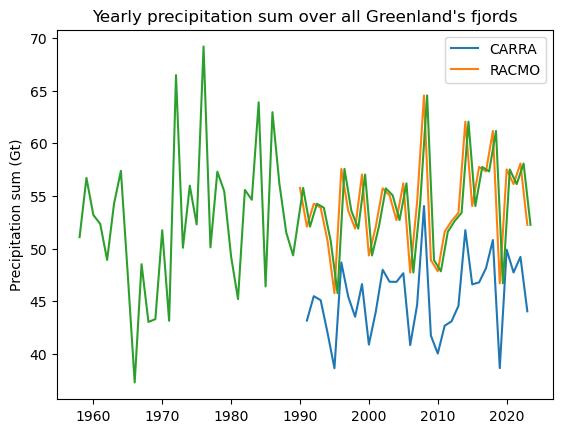

In [176]:
fig, ax = plt.subplots()
(ds_precip_carra_1991_2023_sum['precip'].sum(dim='section_numbers_adjusted')/1e6).plot.line(x='time', ax=ax, label='CARRA')
ds_precip_racmo_1990_2023_sum_yearly['precipcorr'].plot.line(x='time', hue='section_numbers_adjusted', ax=ax, label='RACMO')
dsPrecipFjordsAnnualRACMO_58_23['precipcorr'].sum(dim=['x','y']).plot(ax=ax)
ax.set_ylabel('Precipitation sum (Gt)')
ax.set_xlabel("")
ax.set_title("Yearly precipitation sum over all Greenland's fjords")
ax.legend()



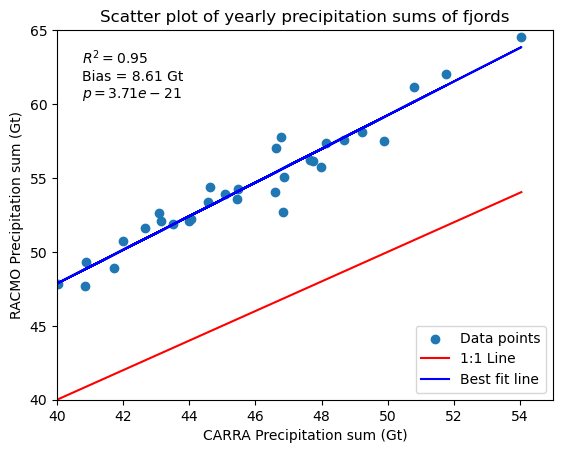

In [125]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Extract data
carra_precip = ds_precip_carra_1991_2023_sum['precip'].sum(dim='section_numbers_adjusted').sel(time=slice('1991', '2023')).values/1e6
racmo_precip = ds_precip_racmo_1990_2023_sum_yearly['precipcorr'].sel(time=slice('1991', '2023')).values


# Calculate statistics
slope, intercept, r_value, p_value, std_err = stats.linregress(carra_precip, racmo_precip)
r_squared = r_value**2
bias = np.mean(racmo_precip - carra_precip)

# Plot scatter plot
fig_corr, ax = plt.subplots()
ax.scatter(carra_precip, racmo_precip, label='Data points')
ax.plot([carra_precip.min(), carra_precip.max()],
        [carra_precip.min(), carra_precip.max()],
        color='red', label='1:1 Line')
ax.plot(carra_precip, slope * carra_precip + intercept, color='blue', label='Best fit line')

# Adding labels, title, and legend
ax.set_xlabel('CARRA Precipitation sum (Gt)')
ax.set_ylabel('RACMO Precipitation sum (Gt)')
ax.set_title('Scatter plot of yearly precipitation sums of fjords')
ax.legend(loc='lower right')
ax.set_xlim([40,55])
ax.set_ylim([40,65])


# Adding text with statistics
stats_text = f'$R^2 = {r_squared:.2f}$\nBias = {bias:.2f} Gt\n$p = {p_value:.2e}$'
plt.text(0.05, 0.95, stats_text, transform=ax.transAxes,
         verticalalignment='top')

plt.show()


In [182]:
ds_precip_monthly = "/Volumes/imau02/rapid/Anneke/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/fjords_only/precip.1990-2023.RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.fjords.nc"
ds_precip_monthly = xr.open_mfdataset(ds_precip_monthly)
# plot


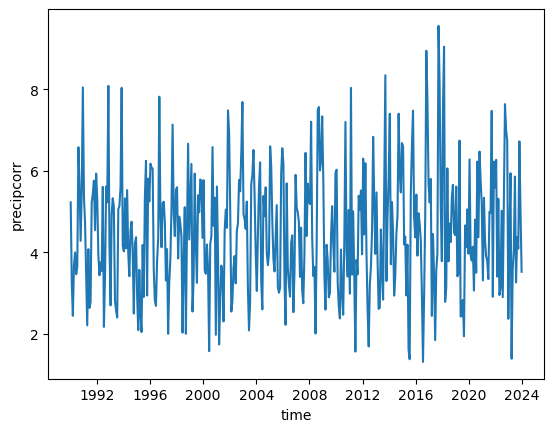

In [181]:
ds_precip_monthly['precipcorr'].sum(dim=['x','y']).plot()


## Map

In [ ]:
racmo_file_years = "/Volumes/imau02/rapid/Anneke/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/fjords_only/precip.1990-2023.RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.fjords.nc"

In [161]:
# open "/Volumes/imau02/rapid/Anneke/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/fjords_only/precip.2022-2023.RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.fjords.nc"

ds_precip_racmo_1990_2023_monthly = xr.open_dataset("/Volumes/imau02/rapid/Anneke/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/fjords_only/precip.1990-2023.RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.fjords.nc")
ds_precip_racmo_1990_2023_yearly = ds_precip_racmo_1990_2023_monthly.resample(time='YS').sum()
ds_precip_racmo_2023 = ds_precip_racmo_1990_2023_yearly.sel(time='2018')
ds_precip_racmo_2023


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/imau02/rapid/Anneke/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/fjords_only/precip.1990-2023.RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.fjords.nc'

In [162]:
# ds_precip_racmo_1990_2023_yearly.to_netcdf(ofile_years)

In [131]:
ds_precip_carra_2008_2023_yearly = "/Volumes/imau02/rapid/Anneke/CARRA/Yearly/RACMOgrid/fjords_only/total_precipitation.CARRA.west_domain.2009-2023.1km.YY.fjords_only.nc"
ds_precip_carra_2023 = xr.open_dataset(ds_precip_carra_2008_2023_yearly).sel(time='2018')
ds_precip_carra_2023

<xarray.Dataset> Size: 32MB
Dimensions:  (time: 1, y: 2700, x: 1496)
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-01-01
  * y        (y) float32 11kB -3.355e+06 -3.354e+06 ... -6.566e+05 -6.556e+05
  * x        (x) float32 6kB -6.39e+05 -6.38e+05 -6.37e+05 ... 8.55e+05 8.56e+05
Data variables:
    precip   (time, y, x) float64 32MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             enmi
    GRIB_centreDescription:  Oslo
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Oslo
    history:                 2024-05-16T15:40 GRIB to CDM+CF via cfgrib-0.9.1...
    description:             sum per year

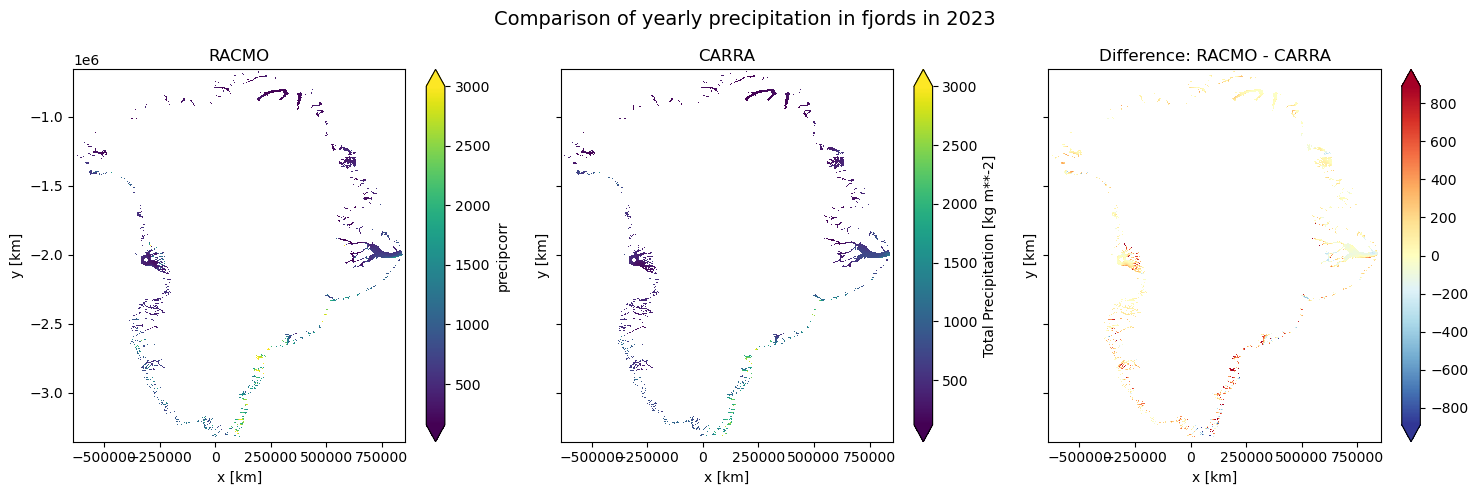

In [160]:

# Create a figure with 3 subplots
fig, axs = plt.subplots(1,3, figsize=(15, 5), sharex=True, sharey=True)

vmax = 3000
# Plot the data from ds_precip_racmo_2023 on the first subplot
(ds_precip_racmo_2023['precipcorr']*1e6).where(ds_precip_racmo_2023['precipcorr']!=0).plot(ax=axs[0], robust=True, vmax=vmax)
axs[0].set_title('RACMO')

# Plot the data from ds_precip_carra_2023 on the second subplot
ds_precip_carra_2023['precip'].plot(ax=axs[1], robust=True, vmax=vmax)
axs[1].set_title('CARRA')
# Calculate the difference between ds_precip_racmo_2023 and ds_precip_carra_2023
# and plot it on the third subplot
((ds_precip_racmo_2023['precipcorr']*1e6) - ds_precip_carra_2023['precip']).plot(ax=axs[2], robust=True, cmap = 'RdYlBu_r')
axs[2].set_title('Difference: RACMO - CARRA')

# axs[0].set_xlim([0, 5e5])
# axs[0].set_ylim([-3.4e6,-2.4e6])

fig.suptitle('Comparison of yearly precipitation in fjords in 2023', fontsize = 14)



# Display the plot
plt.tight_layout()

fig.savefig("/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/freshwaterII/results/figures/precip_comparison_2023.png", dpi=300)


# Adding Qeqertarsuaq

In [34]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
ds_tp = xr.open_dataset("/Volumes/imau02/rapid/Anneke/CARRA/Yearly/RACMOgrid/total_precipitation.CARRA.west_domain.2009-2023.1km.YY.nc")
ds_tp_no_qqt = xr.open_dataset("/Volumes/imau02/rapid/Anneke/CARRA/Yearly/RACMOgrid/fjords_only/total_precipitation.CARRA.west_domain.2009-2023.1km.YY.fjords_only.sum_per_basin.nc")

In [35]:
ds_tp_no_qqt.sum()


<xarray.Dataset> Size: 1kB
Dimensions:                   (time: 15, section_numbers_adjusted: 7)
Coordinates:
  * time                      (time) datetime64[ns] 120B 2009-01-01 ... 2023-...
  * section_numbers_adjusted  (section_numbers_adjusted) float64 56B 1.0 ... 7.0
Data variables:
    precip                    (section_numbers_adjusted, time) float64 840B ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             enmi
    GRIB_centreDescription:  Oslo
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Oslo
    history:                 2024-05-16T15:40 GRIB to CDM+CF via cfgrib-0.9.1...
    description:             sum per year

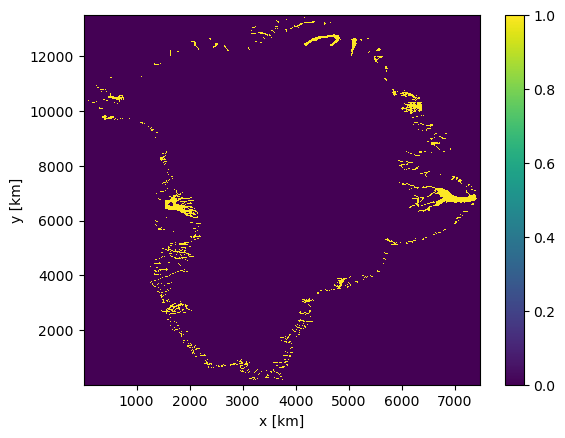

In [8]:
ds_tp['mask_qqt'] = ds_tp['precip'].isel(time=0).copy(data = ds_qqt["fjords_Qeqertarsuaq"].values)

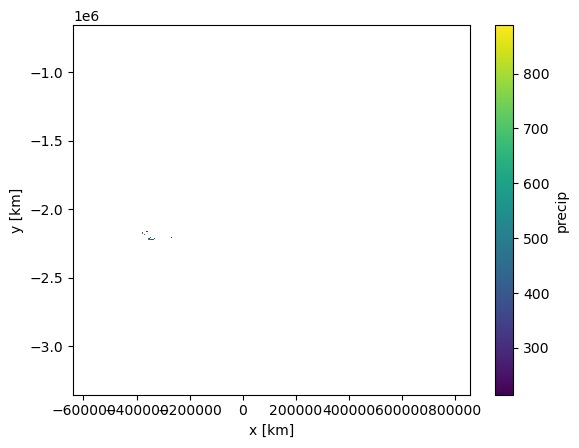

In [11]:
ds_tp_qqt = ds_tp['precip'].where(ds_tp['mask_qqt']==1)
ds_tp_qqt_sum = ds_tp_qqt.sum(dim=['x','y'])
ds_tp_qqt.mean(dim='time').plot()

In [19]:
dict(zip(np.arange(1,8),['SE', 'SW', 'CE', 'CW', 'NE', 'NW', 'NO']))

{1: 'SE', 2: 'SW', 3: 'CE', 4: 'CW', 5: 'NE', 6: 'NW', 7: 'NO'}

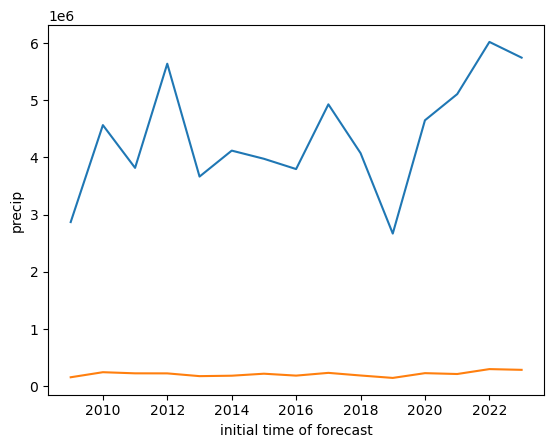

In [23]:
ds_tp_no_qqt.sel(section_numbers_adjusted=4)['precip'].plot()
ds_tp_qqt.sum(dim=['x', 'y']).plot()

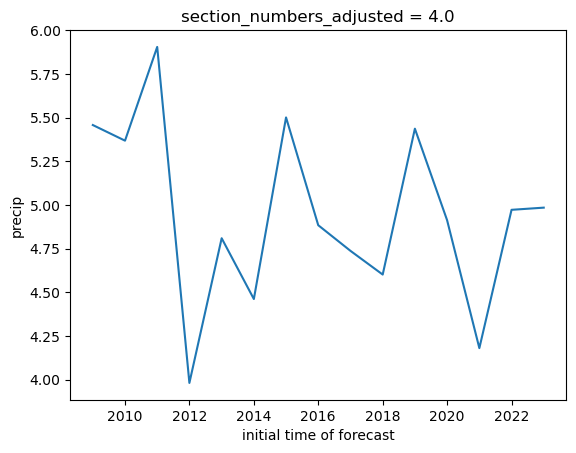

In [26]:
(ds_tp_qqt.sum(dim=['x', 'y'])/ds_tp_no_qqt['precip'].sel(section_numbers_adjusted=4)*100).plot()

# Comparing incl and excl surrounding islands

In [69]:
ds_normal = xr.open_dataset("/Volumes/imau02/rapid/Anneke/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/fjords_only/precip.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.fjords_only.sum_per_basin.nc", decode_times=False)

# Assuming ds_normal is your Dataset or DataArray
new_time_values = pd.to_timedelta(ds_normal.time.values*365, unit='D') + pd.to_datetime('1958-01-15')


In [70]:
ds_fjord_incl_islands = xr.open_dataset("/Users/annek/Downloads/precip.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.fjords_incl_islands.sum_per_basin.nc", decode_times=False)


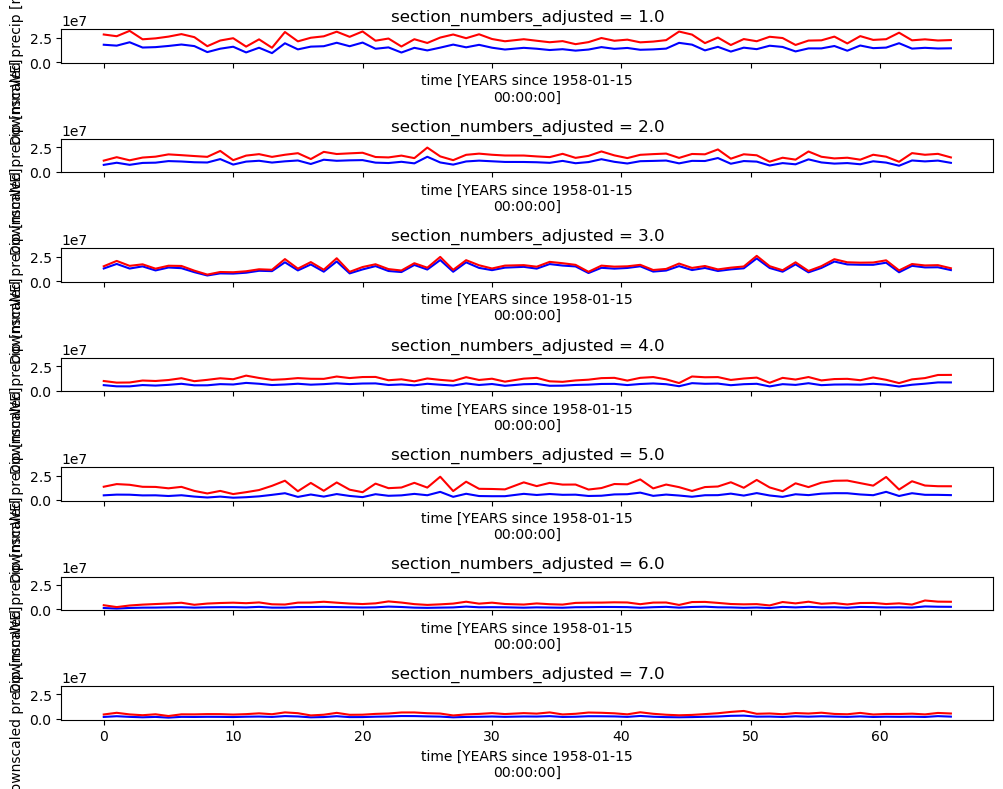

In [71]:
fig, axs = plt.subplots(7, 1, figsize=(10, 8), sharex=True, sharey=True)
for i, section_number in enumerate(ds_normal['section_numbers_adjusted'].values):
    ds_section = ds_normal.sel(section_numbers_adjusted=section_number)
    ds_section['precipcorr'].plot(ax=axs[i], color='blue', label='Normal')
    ds_section_isl = ds_fjord_incl_islands.sel(section_numbers_adjusted=section_number)
    ds_section_isl['precipcorr'].plot(ax=axs[i], color='red', label='Incl islands')




In [82]:
dict_sections = dict(zip(np.arange(1,8),['SE', 'SW', 'CE', 'CW', 'NE', 'NW', 'NO']))
(ds_fjord_incl_islands.mean(dim='time')/ds_normal.mean(dim='time')).to_dataframe().rename(index = dict_sections)


,precipcorr
section_numbers_adjusted,
SE,1.592124
SW,1.636801
CE,1.150488
CW,1.883923
NE,2.818996
NW,2.857503
NO,2.311968
